In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as pxp
import plotly.graph_objs as gph
import scipy.cluster.hierarchy as ch
from scipy.spatial.distance import cdist

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import  KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering

# Tarin and Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Save and get model(s)
import pickle

# Data Preparation

### Data Collection / loading:

## Introduction

In this project, we will apply different stastistical methods, to try and analyse patterns and correlation in different lifestyle factors. This will involve trying to train different machine learning models, to see how precisely these patterns can be used to predict how much carbon is emitted based on the correlating factors.
We will try to answer the following questions: 

- Which machine learning methods did you choose to apply in the application?
- How accurate is your solution of prediction?
- Which are the most decisive factors for carbon emissions for an individual?
- Does internet usage directly affect total carbon emissions?
- Does people who see themselves as "energy efficient" generally have lower total carbon emissions?
- Does obesity affect the social acitivty in individuals?
- Are the people travelling frequently by plane, the ones who are emitting the most carbon?
- Which were the challenges in the project development?

In [3]:
# Reading the data from csv into pandas dataframe:
df = pd.read_csv('./data/Carbon-Emission.csv', index_col=None, na_values=['NA'])

In [48]:
# Viewing the size of the dataframe:
df.shape

(10000, 20)

In [49]:
df.sample(5)


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7881,overweight,female,vegetarian,more frequently,natural gas,public,NaN,never,268,never,773,medium,3,17,5,12,Yes,['Glass'],"['Stove', 'Oven', 'Grill', 'Airfryer']",1066
1455,obese,female,pescatarian,twice a day,natural gas,walk/bicycle,NaN,sometimes,189,very frequently,2,large,2,24,50,10,No,"['Paper', 'Glass']","['Stove', 'Oven', 'Microwave']",3015
6586,overweight,male,pescatarian,more frequently,natural gas,public,NaN,often,276,never,1654,medium,5,16,20,2,Yes,['Plastic'],[],1747
7674,obese,female,vegan,less frequently,natural gas,walk/bicycle,NaN,sometimes,168,never,63,extra large,6,8,47,1,Yes,"['Paper', 'Glass', 'Metal']","['Stove', 'Oven', 'Grill', 'Airfryer']",1827
2454,overweight,male,vegetarian,twice a day,wood,public,NaN,often,80,never,1230,extra large,1,16,18,0,Sometimes,"['Plastic', 'Glass', 'Metal']","['Stove', 'Grill', 'Airfryer']",1107


In [50]:
df.iloc[[7511]]

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7511,obese,male,omnivore,daily,electricity,public,NaN,often,195,rarely,606,medium,2,7,15,24,Sometimes,"['Paper', 'Glass']","['Oven', 'Grill', 'Airfryer']",1574


In [29]:
list(df)

['Body Type',
 'Sex',
 'Diet',
 'How Often Shower',
 'Heating Energy Source',
 'Transport',
 'Vehicle Type',
 'Social Activity',
 'Monthly Grocery Bill',
 'Frequency of Traveling by Air',
 'Vehicle Monthly Distance Km',
 'Waste Bag Size',
 'Waste Bag Weekly Count',
 'How Long TV PC Daily Hour',
 'How Many New Clothes Monthly',
 'How Long Internet Daily Hour',
 'Energy efficiency',
 'Recycling',
 'Cooking_With',
 'CarbonEmission']

In [30]:
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

In [4]:
# Replacing nan values with None, this we do beacuse we know/can see that pepole that dont drive has nan values as vehicle type
df = df.replace(np.nan, 'None')

In [32]:
df.isnull().sum()

Body Type                        0
Sex                              0
Diet                             0
How Often Shower                 0
Heating Energy Source            0
Transport                        0
Vehicle Type                     0
Social Activity                  0
Monthly Grocery Bill             0
Frequency of Traveling by Air    0
Vehicle Monthly Distance Km      0
Waste Bag Size                   0
Waste Bag Weekly Count           0
How Long TV PC Daily Hour        0
How Many New Clothes Monthly     0
How Long Internet Daily Hour     0
Energy efficiency                0
Recycling                        0
Cooking_With                     0
CarbonEmission                   0
dtype: int64

In [33]:
# Getting some insights of the value scope:
df.describe()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000


In [34]:
# Chek numeric values for distribution
num_cols = df.select_dtypes(include=['int64']).columns
df_nums = df[num_cols]
df_nums.dtypes

Monthly Grocery Bill            int64
Vehicle Monthly Distance Km     int64
Waste Bag Weekly Count          int64
How Long TV PC Daily Hour       int64
How Many New Clothes Monthly    int64
How Long Internet Daily Hour    int64
CarbonEmission                  int64
dtype: object

array([[<Axes: title={'center': 'Monthly Grocery Bill'}>,
        <Axes: title={'center': 'Vehicle Monthly Distance Km'}>,
        <Axes: title={'center': 'Waste Bag Weekly Count'}>],
       [<Axes: title={'center': 'How Long TV PC Daily Hour'}>,
        <Axes: title={'center': 'How Many New Clothes Monthly'}>,
        <Axes: title={'center': 'How Long Internet Daily Hour'}>],
       [<Axes: title={'center': 'CarbonEmission'}>, <Axes: >, <Axes: >]],
      dtype=object)

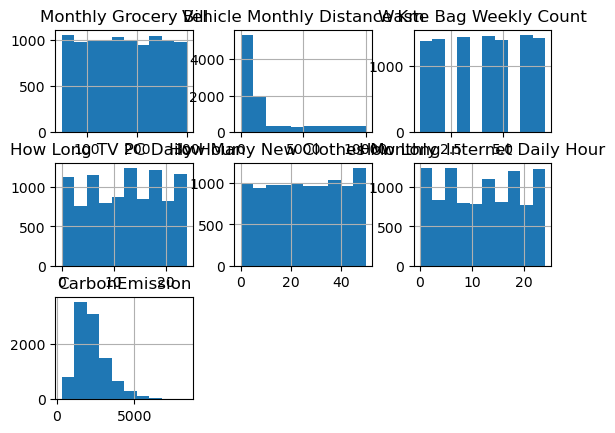

In [36]:
df_nums.hist()

In [5]:
# Encode/transform data numeric
label_encoder = LabelEncoder()

# Making copy of df to a new dataframe called: df_numeric 
df_numeric = df

# Gettning all columns that has object type:
cate_columns = df.select_dtypes(include=['object']).columns

for column in cate_columns:
    df_numeric[column] = label_encoder.fit_transform(df[column])

In [16]:
# Verifying that cols have been encoded:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7511,1,1,0,0,1,1,0,1,195,2,606,2,2,7,15,24,1,4,3,1574
5138,3,0,0,3,0,2,0,0,162,1,30,2,6,22,27,24,1,2,2,1570
9944,3,0,0,2,3,1,0,0,216,1,447,3,6,11,15,5,2,8,1,810
6885,2,0,2,2,2,2,0,0,152,3,16,2,6,5,9,12,0,6,1,2044
1139,0,0,0,2,0,0,3,1,217,3,2258,2,4,11,22,1,2,8,2,2717


In [17]:
corr_matrix = df_numeric.corr()

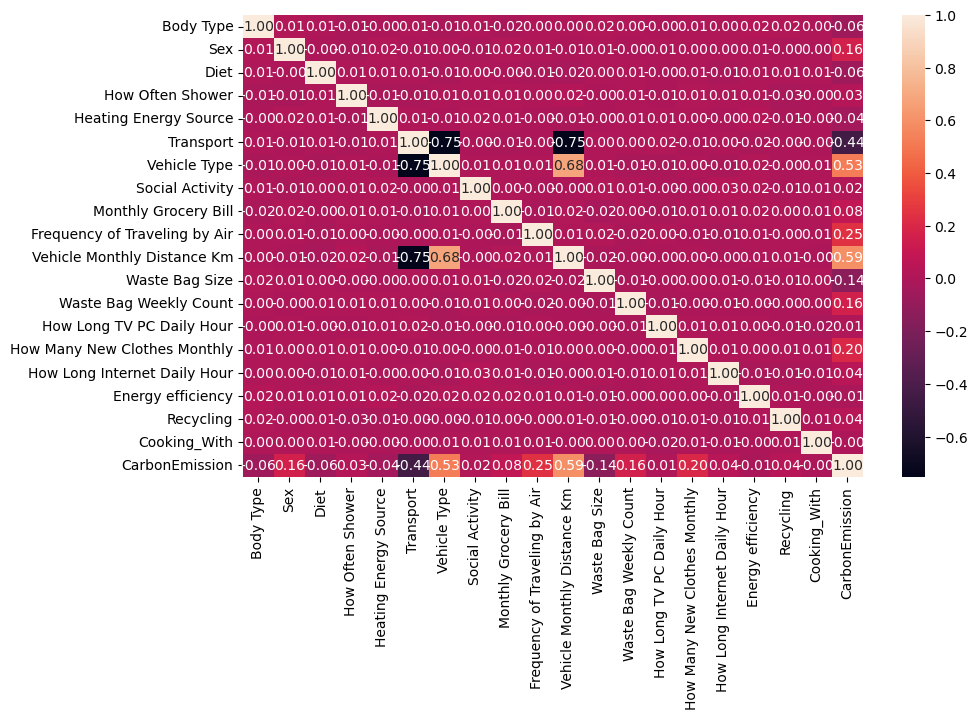

In [66]:
# Heatmap that can show correlation between:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [54]:
# Split dataframe based on sex, and see if theres a difference in the correlation
df_male = df_numeric[df_numeric['Sex'] == 1]
df_male

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,2595
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,1074
5,2,1,3,1,3,1,0,2,144,0,658,1,1,22,18,9,1,3,12,1647
8,2,1,0,0,3,1,0,0,200,0,1376,2,3,3,31,15,2,1,1,2494
11,1,1,3,2,0,2,0,0,111,3,69,2,5,9,4,4,1,15,12,3226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,1,1,0,2,0,1,0,0,120,2,421,1,3,10,33,6,2,9,7,2077
9993,3,1,1,2,3,2,0,2,118,0,78,2,3,8,14,10,1,15,6,1794
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,2408
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,4574


In [55]:
df_female = df_numeric[df_numeric['Sex'] == 0]
df_female

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,2238
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1892
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,4743
6,3,0,2,1,3,0,3,0,56,2,5363,2,4,9,11,19,1,15,0,1832
7,3,0,2,2,0,2,0,2,59,3,54,0,3,5,39,15,0,7,9,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,3,0,0,2,1,1,0,2,226,0,755,2,7,16,17,4,2,8,9,1412
9991,1,0,0,2,0,2,0,0,55,2,82,2,2,19,10,11,1,0,2,1278
9994,0,0,3,2,3,0,5,0,89,2,4482,1,5,15,17,22,1,15,5,2999
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,3084


In [57]:
df_male_corr = df_male.corr()
df_female_corr = df_female.corr()

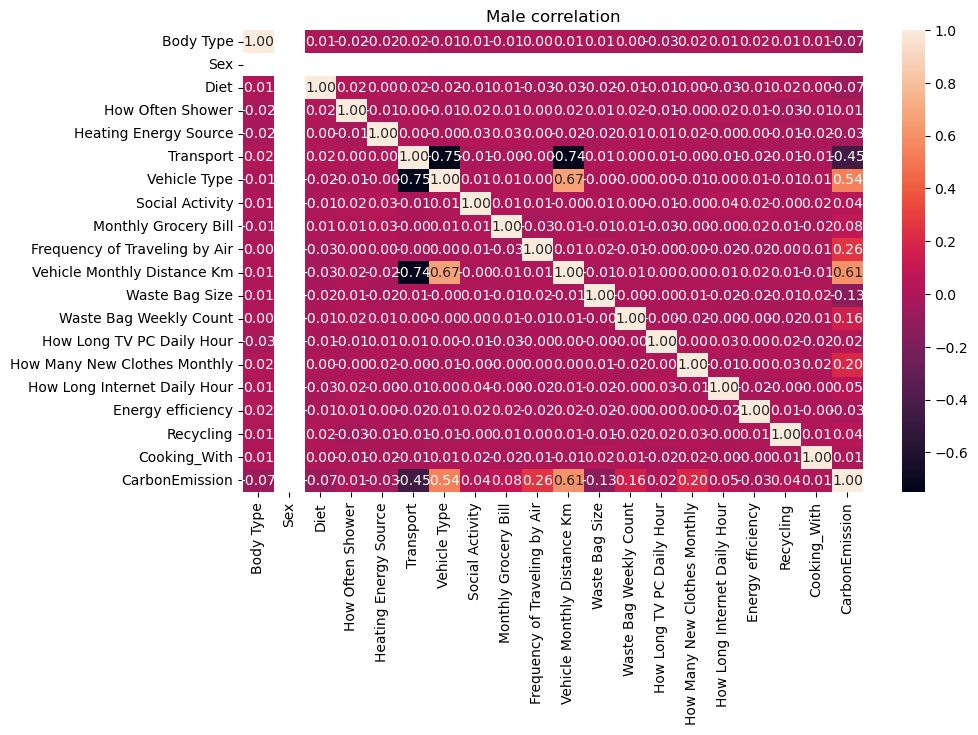

In [63]:
plt.figure(figsize=(10,6))
sns.heatmap(df_male_corr, annot=True, fmt=".2f")
plt.title('Male correlation')
plt.show()

The biggest correlation with carbon emissions, seem to be the monthly travelled distance by vehicle. Other factor with clear correlations seem to be type of transport, vehicle type and frequency of travelling with airplane. There also seem to be a smaller correlation with the amount of clothes people buy

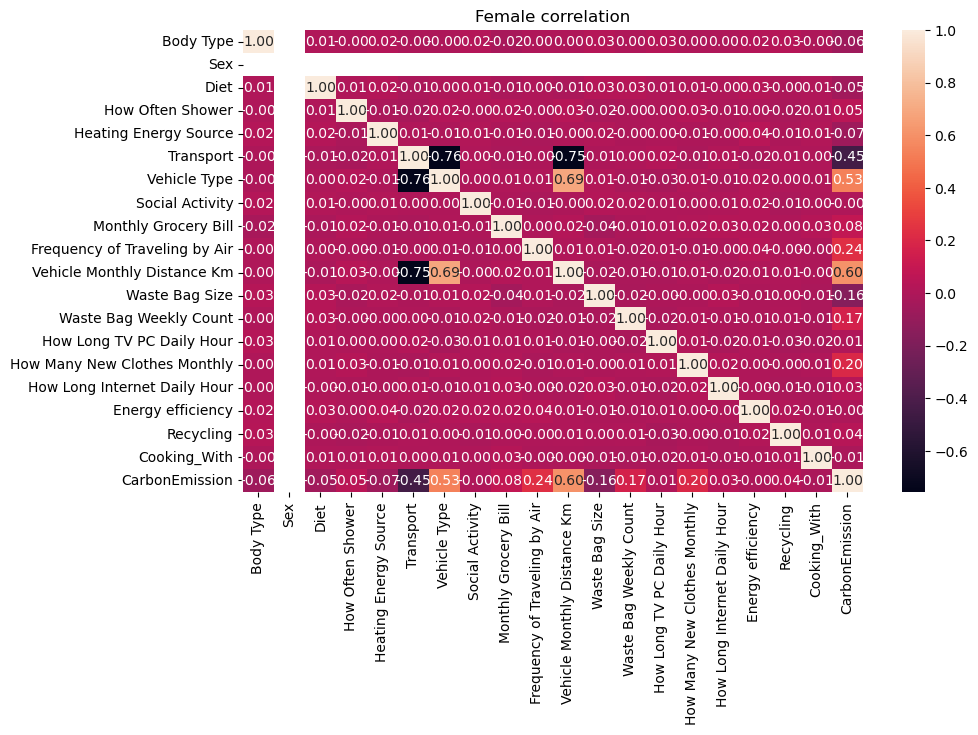

In [65]:
plt.figure(figsize=(10,6))
sns.heatmap(df_female_corr, annot=True, fmt=".2f")
plt.title('Female correlation')
plt.show()

There doesn't really seem to be a difference of how much the factors weigh between males and females

<Axes: >

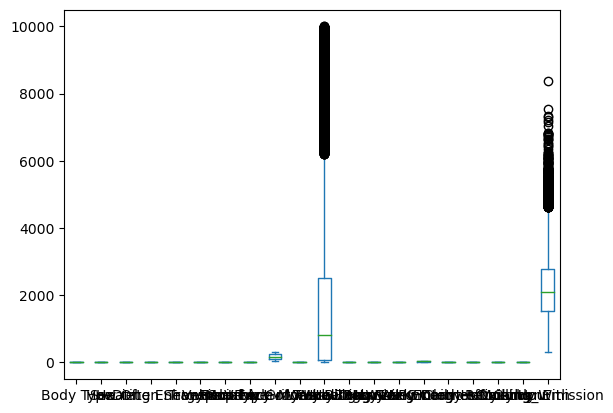

In [19]:
df_numeric.plot.box()

<Axes: >

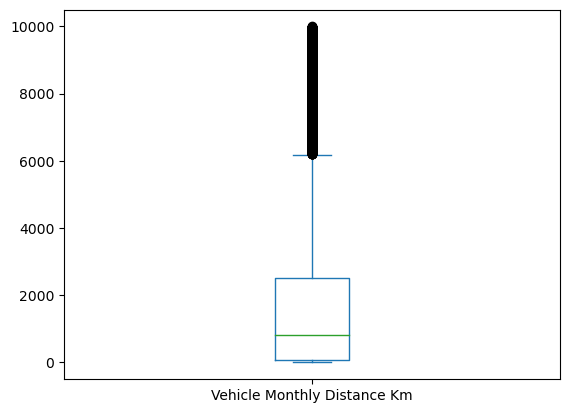

In [39]:
df_nums['Vehicle Monthly Distance Km'].plot.box()

In [42]:
med = df_nums['Vehicle Monthly Distance Km'].median()
df_nums['Vehicle Monthly Distance Km'].max() - med

9176.0

As we can see, the distribution of distance travelled by vehicle is very skewed, with 75% of the data lying beneath 3000 km pr month, with quite a few outlier being outragerously above the median. This might still be an accurate representation though, since some individuals just might have to travel that much

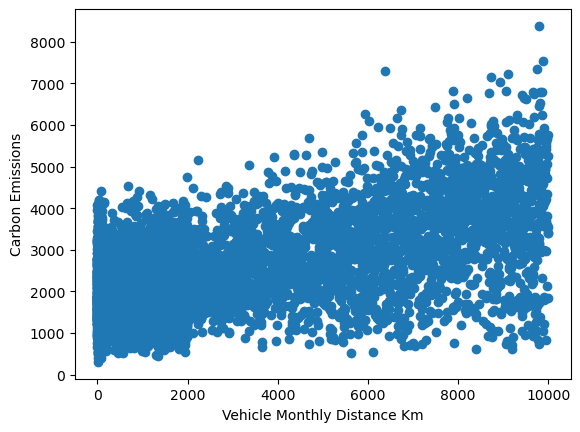

In [71]:
plt.xlabel('Vehicle Monthly Distance Km')
plt.ylabel('Carbon Emissions')
plt.scatter(df_numeric['Vehicle Monthly Distance Km'], df_numeric['CarbonEmission'])
plt.show()

Let's see if people are as accurate as they think, when they say they're energy efficient!

In [74]:
test = df_numeric.iloc[[6550]]
test

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
6550,3,1,2,3,3,2,0,2,157,3,13,3,2,20,45,12,2,3,2,2372


In [85]:
grouped_data = df.groupby('Energy efficiency')

grouped = df.groupby('Energy efficiency')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Energy efficiency,mean,sum
0,No,2286.656628,7365321
1,Sometimes,2269.151314,7858071
2,Yes,2252.135404,7468081


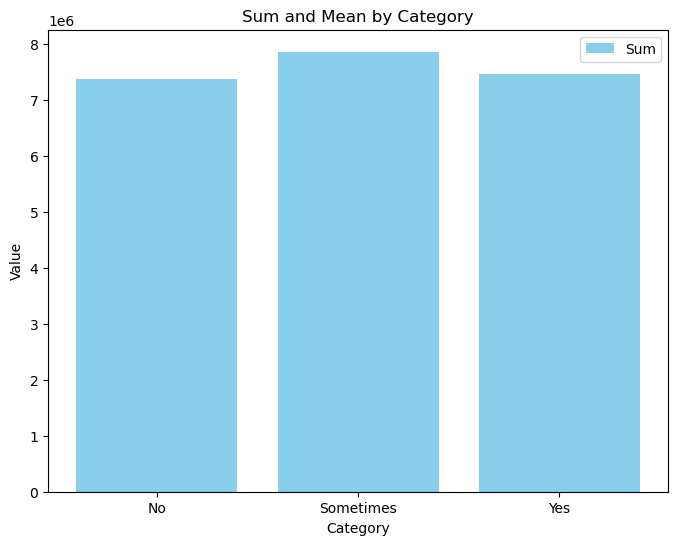

In [99]:
plt.figure(figsize=(8, 6))
plt.bar(grouped['Energy efficiency'], grouped['sum'], color='skyblue', label='Sum')
# plt.bar(grouped['Energy efficiency'], grouped['mean'], color='orange', label='Mean')
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Category')
plt.legend()
plt.show()

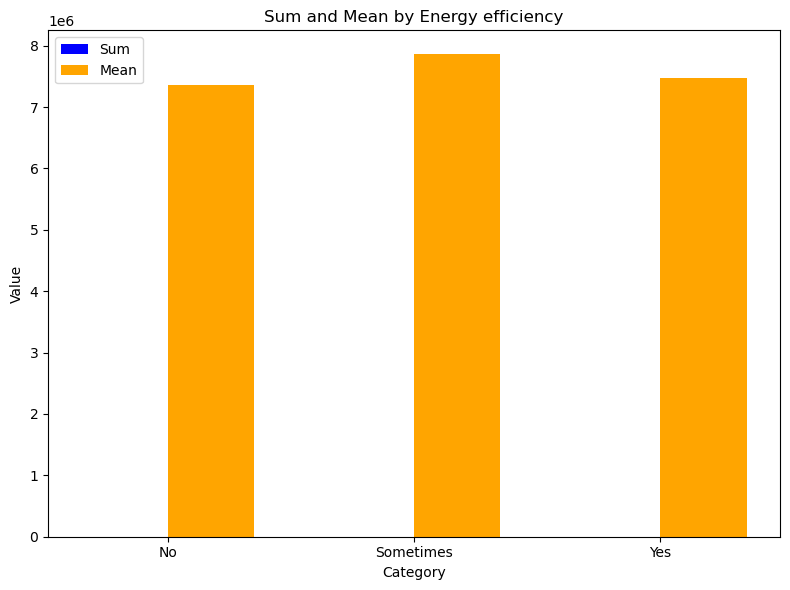

In [102]:
plt.figure(figsize=(8, 6))

# Define the width of each bar
bar_width = 0.35

# Define the positions for the bars
index = np.arange(len(grouped['Energy efficiency']))

# Create side-by-side bars for 'Sum' and 'Mean'
plt.bar(index, grouped['mean'], bar_width, color='blue', label='Sum')
plt.bar(index + bar_width, grouped['sum'], bar_width, color='orange', label='Mean')

# Add labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Energy efficiency')
plt.xticks(index + bar_width / 2, grouped['Energy efficiency'])
plt.legend()

plt.tight_layout()
plt.show()

0    2286.656628
1    2269.151314
2    2252.135404
Name: mean, dtype: float64

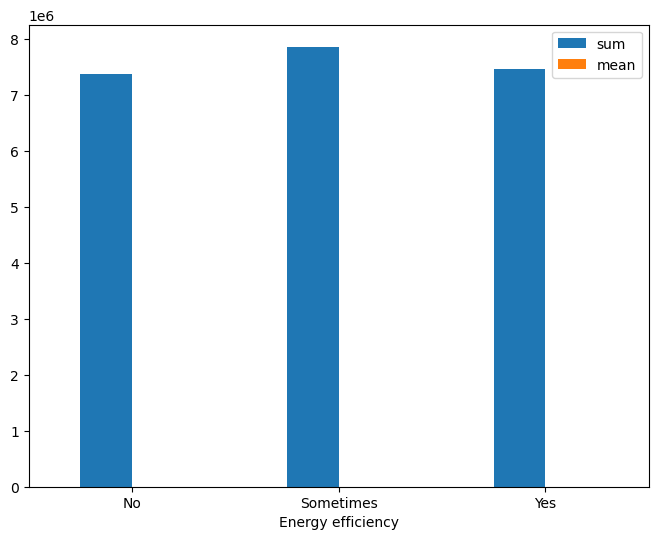

In [115]:
grouped['sum'] = grouped['sum'].astype(float)
grouped['mean'] = grouped['mean'].astype(float)
grouped.plot.bar(x='Energy efficiency', y=['sum','mean'], figsize=(8, 6), rot=0)

We can see that people say that the are energy efficient generally tend to have a little bit lower carbon emission in total, but the difference really is only about 1,5% lower than the 'No' category

## Supervised Machine learning

## Unsupervised machine learning

### Applying the data to K-means, Hierarchical clustering and DBSCAN

The perpose of applying these clustering models, is to see if, there are patterns in the data, that we haven't been able to see before and to get better insight into the data and the different types of people in the dataset.

#### Setup models for testing

c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\clust

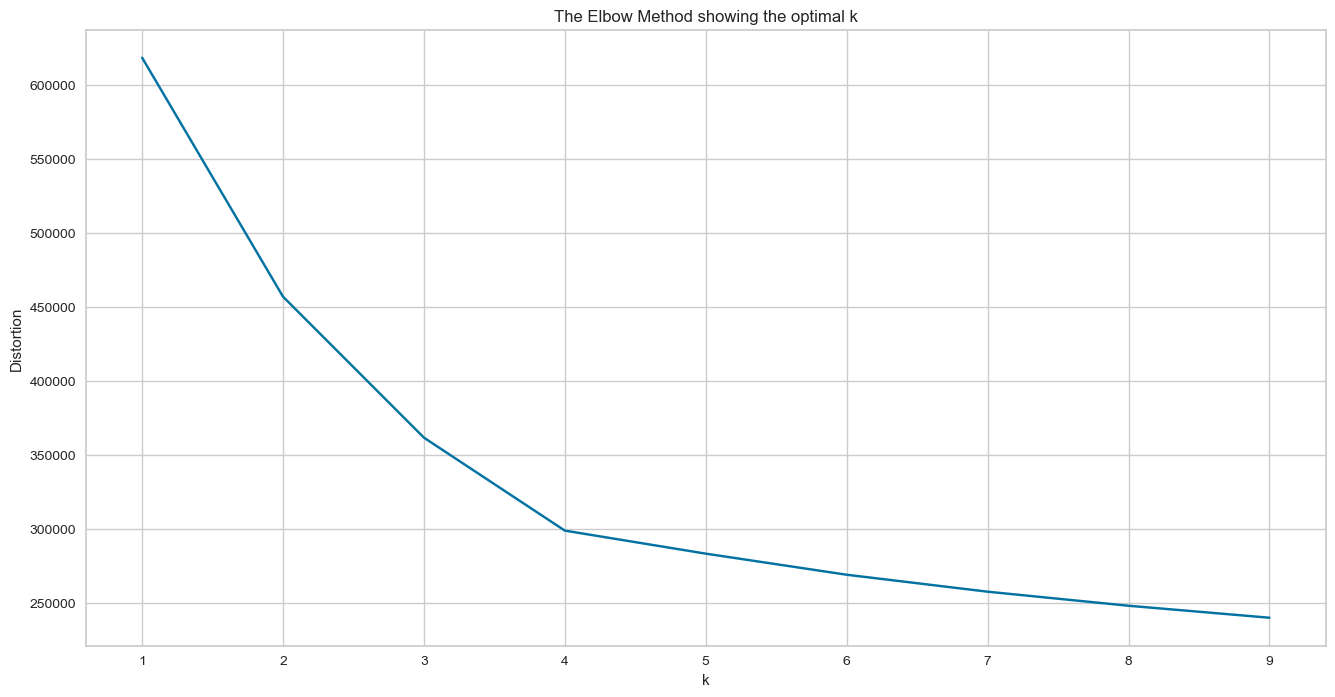

In [191]:
scaler = StandardScaler()
X = df_numeric
X[['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'CarbonEmission']] = scaler.fit_transform(X[['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'CarbonEmission']])

X = X.values


# Using the elbow method to find the optimal number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

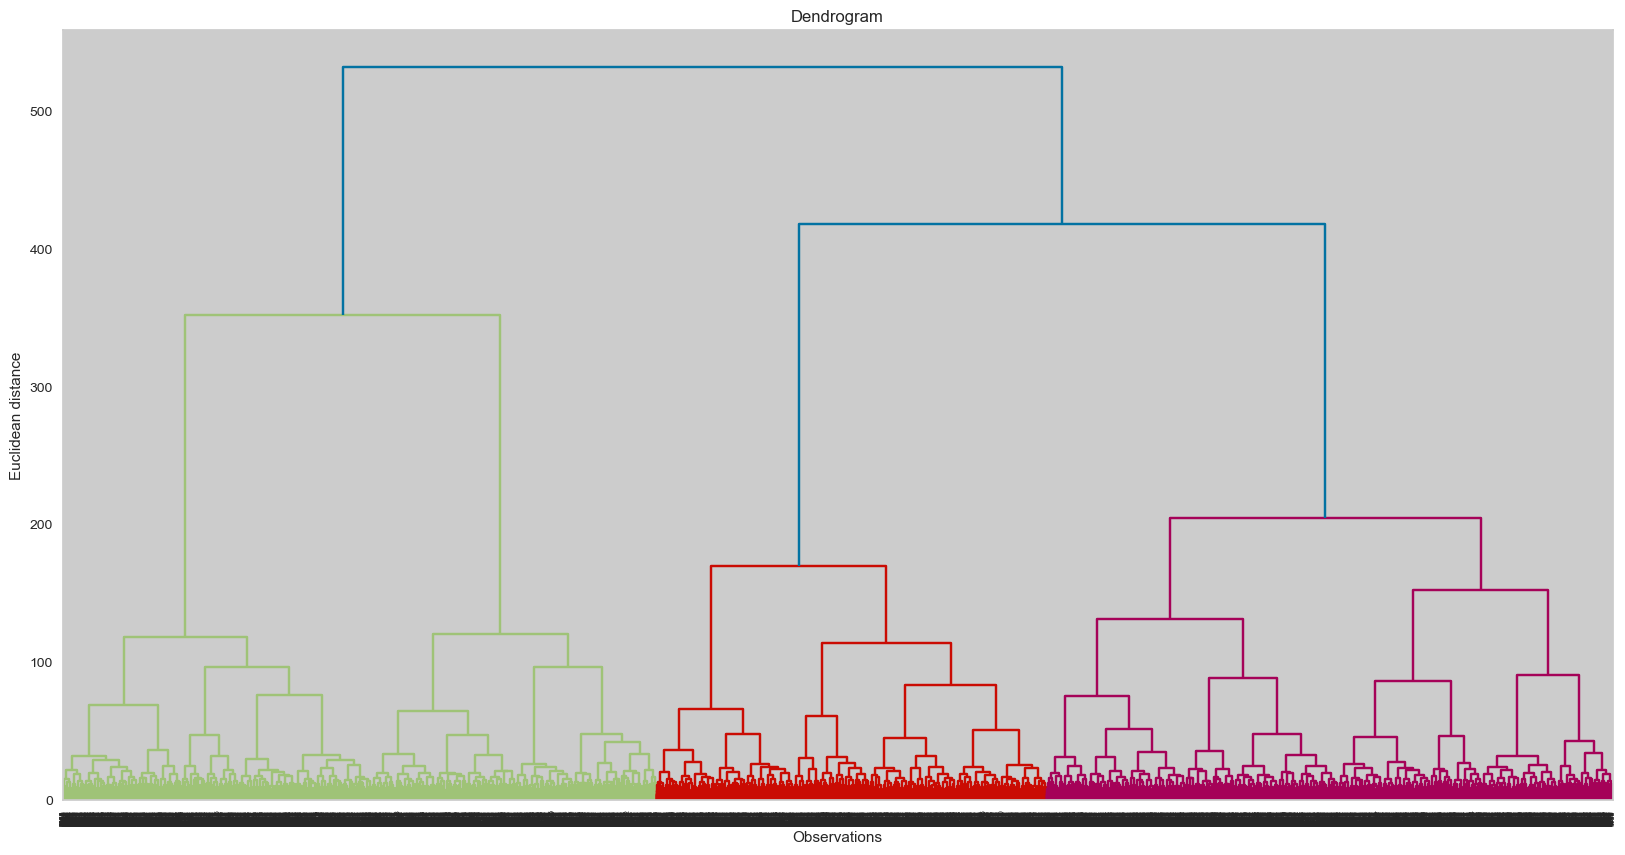

In [192]:
plt.figure(figsize=(20,10))

dendogram = ch.dendrogram(ch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean distance')
plt.show()

In [193]:
n_clusters = 4
model = AgglomerativeClustering(n_clusters, affinity = 'euclidean', linkage = 'ward')
model.fit(X)

c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [194]:
X

array([[ 2.        ,  0.        ,  1.        , ...,  2.        ,
        13.        , -0.03060786],
       [ 1.        ,  0.        ,  3.        , ...,  2.        ,
         9.        , -0.37061544],
       [ 2.        ,  1.        ,  0.        , ...,  2.        ,
         5.        ,  0.32020922],
       ...,
       [ 2.        ,  0.        ,  3.        , ...,  8.        ,
         1.        ,  0.10598479],
       [ 3.        ,  1.        ,  2.        , ...,  5.        ,
         8.        ,  2.26493467],
       [ 1.        ,  1.        ,  1.        , ..., 11.        ,
         3.        , -1.41815325]])

In [195]:
Y = model.fit_predict(X)
Y

c:\Users\Oscar\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([2, 2, 1, ..., 3, 0, 3], dtype=int64)

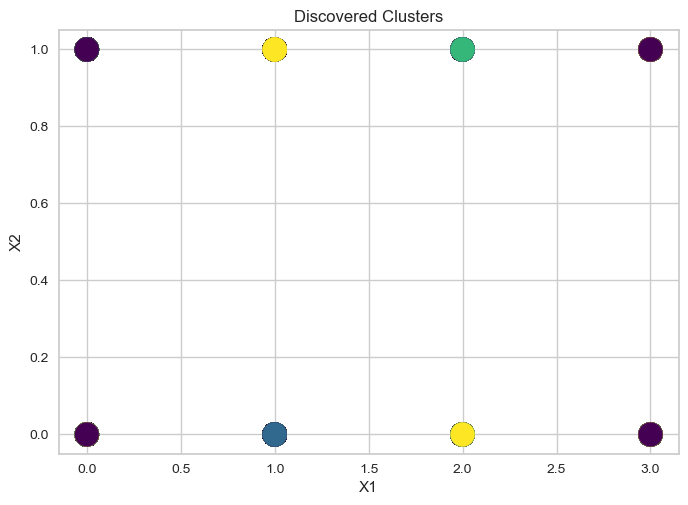

In [196]:

plt.scatter(X[:, 0], X[:, 1], s=300, c=Y, cmap='viridis')
plt.title('Discovered Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()


#### K-means

In [197]:
""" X = df_numeric
# Standardizing the data 
X[['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'CarbonEmission']] = scaler.fit_transform(X[['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'CarbonEmission']])
"""
X = df[['Vehicle Monthly Distance Km', 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

X = X.values

X

array([[-0.65767654,  0.77702456, -0.0123601 , -0.72321847,  0.06062053,
        -1.4964022 ],
       [-0.7302508 , -0.82894729, -0.51480321, -0.4417667 ,  0.87705868,
        -0.94671409],
       [ 0.15905464, -0.49667725, -1.51968944,  0.26186273,  1.48938729,
        -0.80929206],
       ...,
       [-0.69883806,  1.71845634,  0.49008301, -0.16031493, -1.36814623,
         1.66430443],
       [ 2.40344061,  0.07095073,  0.49008301,  0.96549216, -0.75581762,
        -0.94671409],
       [ 2.85982798, -0.81510271, -0.0123601 , -0.16031493, -1.30010972,
        -1.63382422]])

In [198]:

distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10).fit(X)
    model.fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]) 
print("Distortion: ", distortions)

Distortion:  [2.2251808448755077, 2.082823310281535, 1.9881704433431384, 1.9065893812628918, 1.8396647125948824, 1.7855565689700024, 1.7459418605115822, 1.7009002376160967]


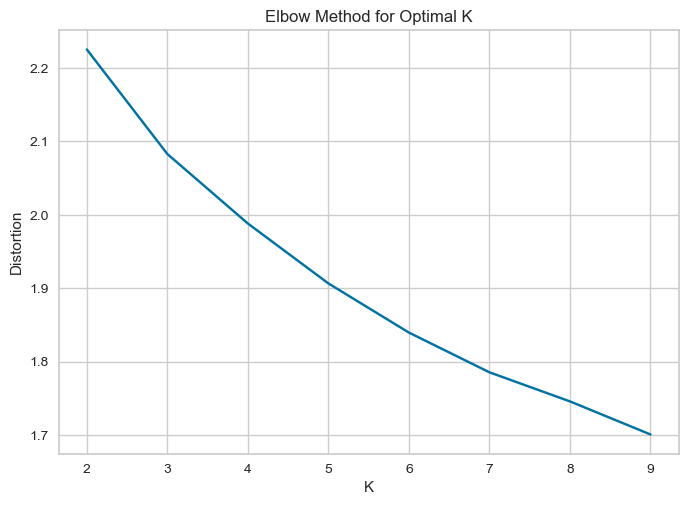

In [199]:
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

In [200]:
k_clusters = 4

In [201]:
kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=20)

In [202]:
kmeans.fit(X)

KMeans(n_clusters=4, n_init=20)

In [203]:
scores = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X)
    score = metrics.silhouette_score(X, model.labels_, metric='euclidean', sample_size=len(X))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.1982611866059886

Number of clusters = 3
Silhouette score = 0.14400572704194223

Number of clusters = 4
Silhouette score = 0.13086883364548854

Number of clusters = 5
Silhouette score = 0.13849050815349398

Number of clusters = 6
Silhouette score = 0.136729567360642

Number of clusters = 7
Silhouette score = 0.13827934974476105

Number of clusters = 8
Silhouette score = 0.13558016992850258

Number of clusters = 9
Silhouette score = 0.1422552535585255


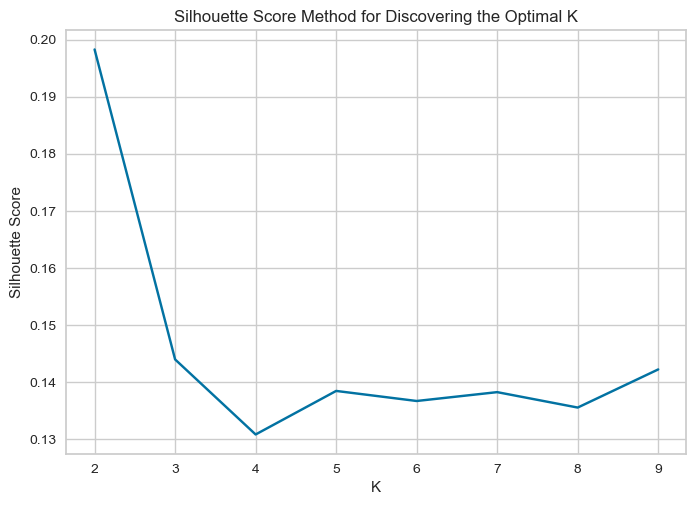

In [204]:
# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

In [205]:
y = kmeans.predict(X)
y

array([3, 3, 2, ..., 1, 0, 0])

In [206]:
print(kmeans.labels_)

[3 3 2 ... 1 0 0]


Cluster  0 :  (1711, 6)


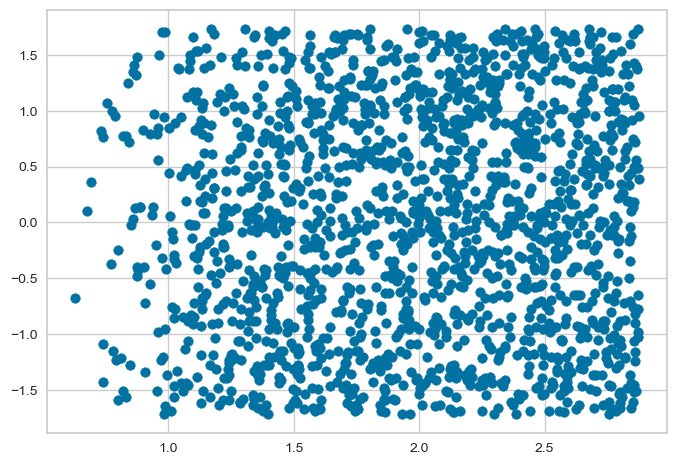

Cluster  1 :  (3090, 6)


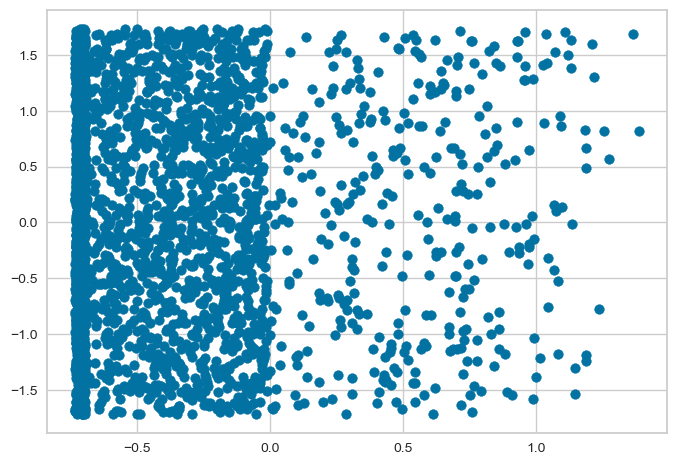

Cluster  2 :  (2542, 6)


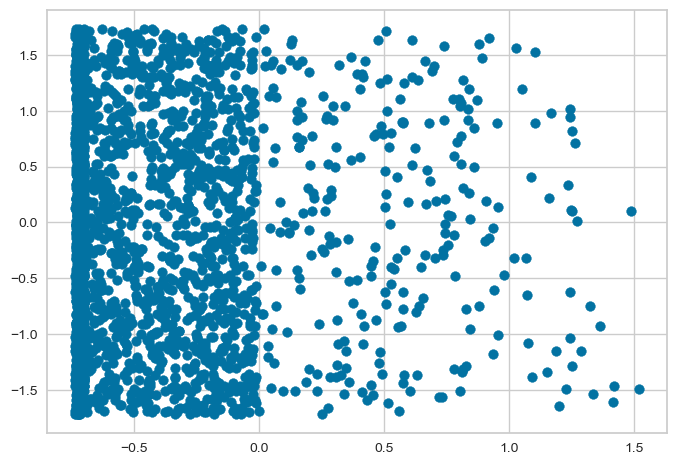

Cluster  3 :  (2657, 6)


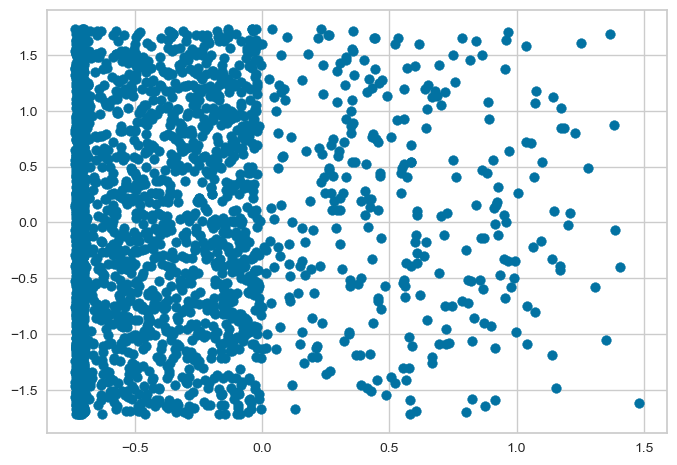

In [207]:
for i in range(k_clusters):
    # slice the cluster
    cluster = X[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

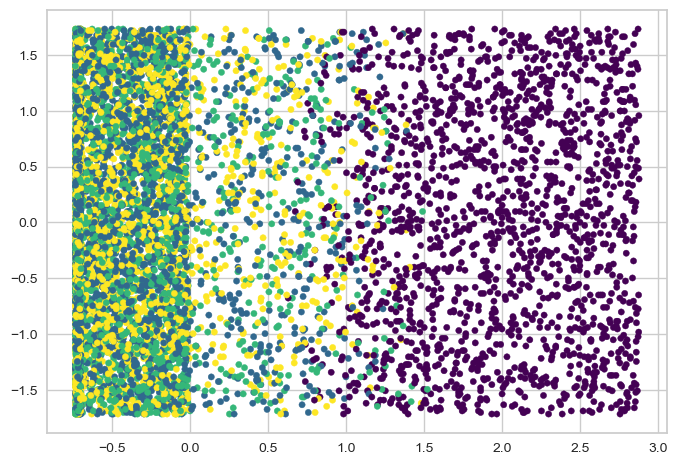

In [208]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='viridis')

plt.grid(True)
plt.show()

In [209]:
print(kmeans.cluster_centers_)

[[ 1.96847410e+00  1.37760725e-02  1.05449624e-02 -1.37494537e-02
   1.76954579e-03  1.37944006e-02]
 [-4.03569768e-01  4.55495495e-02 -2.76645894e-02  1.58347576e-01
   5.28299330e-03  1.05828487e+00]
 [-4.16038973e-01 -8.09315515e-02 -4.83053233e-02  8.66032589e-01
   2.08790792e-02 -7.46469018e-01]
 [-4.00240592e-01  1.57025564e-02  7.15378844e-02 -1.00350591e+00
  -2.72461029e-02 -5.22922954e-01]]


In [210]:
k = 5
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X)

array([1, 4, 4, ..., 2, 0, 0])

In [211]:
score = silhouette_score(X, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.140


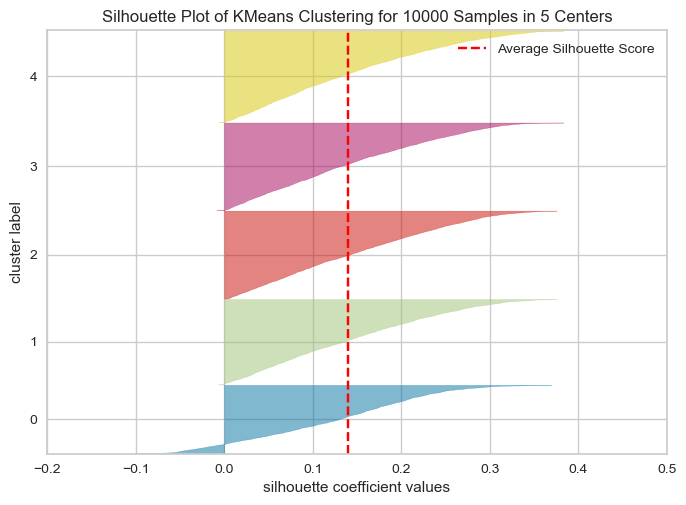

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [212]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()  

#### Evaluate the quality of the clustering

In [215]:
# evaluate the quality of the clustering by calculating a silhouette score and recommend the cluster configuration with higher score


